##Objectives: 
Learning the segmentation masks from the MRIs. MRIs are modified with motion blurs and rotations, and therefore result in multiple images. \\
Each of these image is applied with a weight to be combined linearly. \\
This linearly synthesized image is therefore used as input to the U-net. \\

Therefore, Our network would optimize 1) the weights associated to each modified image, 2) the weights inside the U-Net for classification 


### To Dos: 
The whole pipeline: 

1) load in MR image(s)
 - Normalized Images
 - maybe crop
 - label images
 - save data to test/train x&y as well as TRUTH data
    - define flair as test/train, truth/labels as seg file
 - create input pipeline for generating training/testing batches

2) blur it and add in rotations (in k-space maybe?) \\
  if in k space, then need to convert them back to image space (ifft2d) \\
  This is going to be our physical layer

3) Mix the modified MRIs in a linear layer (make the weights trainable) 

4) Train the network and evaluate the performances






## Load in the images

In [ ]:
# Mounting my google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Specify Your Name




In [ ]:
user_name = 'Aidan' # specify your name here

In [ ]:
def get_working_dir(user_name):
    drive_dir = '/content/drive';
    shared_drive_dir = 'Shareddrives';
    my_drive_dir = 'MyDrive';
    data_fold = 'BME 548 deep imaging/MICCAI_BraTS2020_TrainingData';

    if len(user_name) == 0 or user_name == 'Ruochen':
        temp_dir = os.path.join(drive_dir,my_drive_dir);
        data_folder_dir = os.path.join(temp_dir,data_fold);
    elif user_name == 'Aidan':
        temp_dir = os.path.join(drive_dir,my_drive_dir); #i put it in MyDrive instead
        data_folder_dir = os.path.join(temp_dir,data_fold);
    return data_folder_dir

In [ ]:
import os 

data_fold = get_working_dir(user_name);
print(get_working_dir(user_name))
os.chdir(get_working_dir(user_name))
os.getcwd()

/content/drive/MyDrive/BME 548 deep imaging/MICCAI_BraTS2020_TrainingData


'/content/drive/.shortcut-targets-by-id/1Om38adYiS-vEn7Zxny0iNPbFbBeINg5W/BME 548 deep imaging/MICCAI_BraTS2020_TrainingData'

### Read in multiple subjects to construct an image

  - Gives us the center slices of the MRI

In [ ]:
import numpy as np
def show_slices(slices):
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

def extract_slices(img_data, axis='h', display = False):
    width, length, height = img_data.shape
    center_width = (width - 1) // 2  # // for integer division
    center_length = (length- 1) // 2
    center_height = (height - 1) // 2
    center_width, center_length, center_height
    if (axis =='h'):
        return_slice = (img_data[:,:,center_height]);
    elif(axis =='l'):
        return_slice = (img_data[:,center_length,:]);
    elif(axis == 'w'):
        return_slice = (img_data[center_width,:,:]);

    if display:
        show_slices([return_slice])
    return np.squeeze(return_slice);


### Load in the Flair Images (labels and train data)

  - data_set --> array of all images
  - gold_standard --> array of all labels for Flair

In [ ]:
import glob
import nibabel as nib


find_data_fold = os.path.join(data_fold, '*');

img_headers = ['flair', 'seg', 't1', 't1ce', 't2'] #there are 370 total training subjects
load_in_random = 'BraTS20_Training_137/BraTS20_Training_137_flair.nii.gz';
image = nib.load(load_in_random)
image.shape
i = 0; 
j = 0;
print_level = 1;

for name in glob.glob(find_data_fold):

# This loop concatenates all the files found from the subject folders into 
# [x,240,240] with x be the number of total subjects inside the dataset

    # Find only the path not the file (to filter out some csv file present)
    if os.path.isdir(name):  
        if (print_level > 2):
            print("looked into folder : " + name);
        # flair image string (wild card)
        file_str = os.path.join(name,'*flair.nii.gz')

         # find the flair files
        for data_file in glob.glob(file_str):
            # load and convert it to managable data type
            image = nib.load(data_file);
            img_data = image.get_fdata();
            # get the horizontal slices (other options available in the function)
            slice_h = extract_slices(img_data)
            img_con = slice_h[np.newaxis,:,:];
            if (print_level > 0):
                print('start concatenating ', i+1,' slices' + ' ---->train/test');
            if i == 0:
                data_set = img_con; #Subject-D array 
            else:
                data_set = np.concatenate((data_set,img_con),axis = 0);
            # print(data_set.shape) debug uses, no long use it now
            i += 1; # increment at the end

        seg_str = os.path.join(name,'*seg.nii.gz');

        for seg_file in glob.glob(seg_str):
            # load and convert it to managable data type
            image = nib.load(seg_file);
            img_data = image.get_fdata();
            # get the horizontal slices (other options available in the function)
            slice_h = extract_slices(img_data)
            img_con = slice_h[np.newaxis,:,:];
            if(print_level > 0):
                print('start concatenating ', j+1,' slices' + ' label');
            if j == 0:
                gold_standard = img_con;
                
            else:
                gold_standard = np.concatenate((gold_standard,img_con),axis = 0);
            # print(data_set.shape) debug uses, no long use it now
            j += 1; # increment at the end
print('done');

start concatenating  1  slices ---->train/test
start concatenating  1  slices label
start concatenating  2  slices ---->train/test
start concatenating  2  slices label
start concatenating  3  slices ---->train/test
start concatenating  3  slices label
start concatenating  4  slices ---->train/test
start concatenating  4  slices label
start concatenating  5  slices ---->train/test
start concatenating  5  slices label
start concatenating  6  slices ---->train/test
start concatenating  6  slices label
start concatenating  7  slices ---->train/test
start concatenating  7  slices label
start concatenating  8  slices ---->train/test
start concatenating  8  slices label
start concatenating  9  slices ---->train/test
start concatenating  9  slices label
start concatenating  10  slices ---->train/test
start concatenating  10  slices label
start concatenating  11  slices ---->train/test
start concatenating  11  slices label
start concatenating  12  slices ---->train/test
start concatenating  12 

### save the Train Data

In [ ]:
with open ('train_dataset_flair.npy', 'wb') as f:
  np.save(f, data_set)

In [ ]:
with open('train_dataset_flair.npy', 'rb') as f:
  data_set = np.load(f)

Save the Label Data

In [ ]:
with open ('label_dataset_flair.npy', 'wb') as f:
  np.save(f, gold_standard)

In [ ]:
with open('label_dataset_flair.npy', 'rb') as f:
  gold_standard = np.load(f)

In [ ]:
data_set.shape

(369, 240, 240)

## Plotting Images

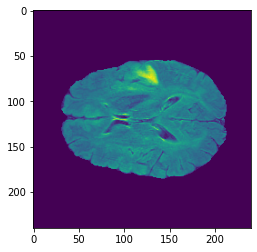

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

img_data = data_set[1,:,:];
# plot examples
plt.imshow(img_data);


In [ ]:

image_2 = np.array(img_data).astype(np.float32)
# image_2 = ImageOps.grayscale(image_2)
# image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
# image_2.shape
# type(img_data)

# image_2 = np.rot90(image_2,axes=(0,2))
# image_2 = np.rot90(image_2,axes=(1,2))
# image_2.shape #there's 155 brain slices here


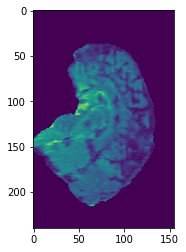

In [ ]:
plt.imshow(image_2)


In [ ]:
# image_small = np.squeeze(image_2, axis=0).shape
# plt.imshow(image_small)

## Create Pipeline for Train and Test

  - Split Data - 80% train, 20% test

In [ ]:
y_train = gold_standard[0:296,:,:]
x_train = data_set[0:296,:,:]
y_train[np.where(y_train>3)] = 3;   ## UNCOMMENT FOR CATEGORICAL
# y_train[np.where(y_train>0)] = 1; ## UNCOMMENT FOR BINARY

y_test = gold_standard[296:,:,:]
x_test = data_set[296:,:,:]
y_test[np.where(y_test>3)] = 3;   ## UNCOMMENT FOR CATEGORICAL
# y_test[np.where(y_test>0)] = 1; ## UNCOMMENT FOR BINARY

print(np.unique(gold_standard))

[0. 1. 2. 3.]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([0., 1., 2., 3.])

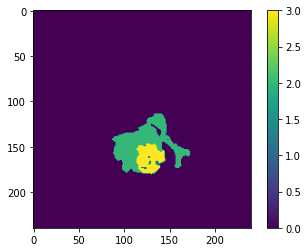

In [ ]:
a = y_train[90,:,:]
print(a)
plt.imshow(a)
plt.colorbar()
np.unique(y_test)

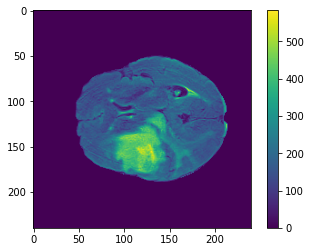

In [ ]:
a = x_train[90,:,:]
print(a)
plt.imshow(a)
plt.colorbar()
np.unique(x_train)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.1989e+04, 2.3081e+04,
       2.5851e+04])

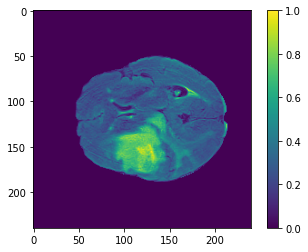

In [ ]:
a = a/np.max(np.max(a))
print(a)
plt.imshow(a)
plt.colorbar()
np.unique(x_train)

### Initialize Motion blur kernels

In [ ]:
import numpy as np
import tensorflow as tf

vert_down = np.array([[0, 1/3, 0],
                      [0, 2/3, 0],
                      [0,  1 , 0]]);

vert_up = np.array([[0, 1, 0],
                    [0, 2/3, 0],
                    [0, 1/3, 0]]);

horiz_left = np.array([ [0, 0,  0],
                        [1, 2/3, 1/3],
                        [0, 0,  0]]);

horiz_right = np.array([[0, 0,  0],
                        [1/3, 2/3, 1],
                        [0, 0, 0]]);

up_left = np.array([[1, 0,  0],
                    [0, 2/3, 0],
                    [0, 0, 1/3]]);

up_right = np.array([[0, 0,  1],
                    [0, 2/3, 0],
                    [1/3, 0, 0]]);

down_right = np.array([[1/3, 0,  0],
                        [0, 2/3, 0],
                        [0, 0,   1]]);

down_left = np.array([[0, 0, 1/3],
                      [0, 2/3, 0],
                      [1, 0,   0]]);


In [ ]:
blur_kernels_np = [vert_down, vert_up, horiz_left, horiz_right, up_left, up_right, down_right, down_left]*10; # save all kernels to one array
# np.array(blur_kernels).shape
before_tensorflow = np.empty([3,3,1,8]);
for i in range(8):
    before_tensorflow[:,:,0,i] = blur_kernels_np[i];
print(before_tensorflow.shape)
# # convert to tensor 
blur_kernels = tf.Variable(before_tensorflow, trainable = False, dtype = tf.float32)
# blur_kernels = tf.expand_dims(blur_kernels,axis = -2); # we want it to be (3,3,1,8) for the custom layer (h,w,input_channel, output_channel)
# blur_kernels.shape

(3, 3, 1, 8)


# Custom Layer


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D

class Conv2D_Blur(tf.keras.layers.Layer):
  def __init__(self):           #kernel_size, strides, activation, filters
    super(Conv2D_Blur, self).__init__()
    # for i in range(8):
    #     print(blur_kernels[:,:,0,i])
    self.strides = 1

  def build(self, input_shape):
    
    self.k = blur_kernels
    
  def call(self, input):

    x = tf.nn.conv2d(input, self.k, [1, self.strides, self.strides, 1], padding='SAME') 
    #self.k = 8 filters/blur kernels
                  
    return x

In [ ]:
def create_blur_layer():
    input_layer = Input(shape=(240, 240, 1))
    blurred_input = Conv2D_Blur()(input_layer);
    model = tf.keras.Model(inputs=input_layer, outputs=blurred_input);
    return model

blur_layer = create_blur_layer();
test_blur_slice = x_train[1:2,:,:];
blurred = blur_layer.predict(test_blur_slice);
# blur_layer.shape

## Check with signal convolution 2d 

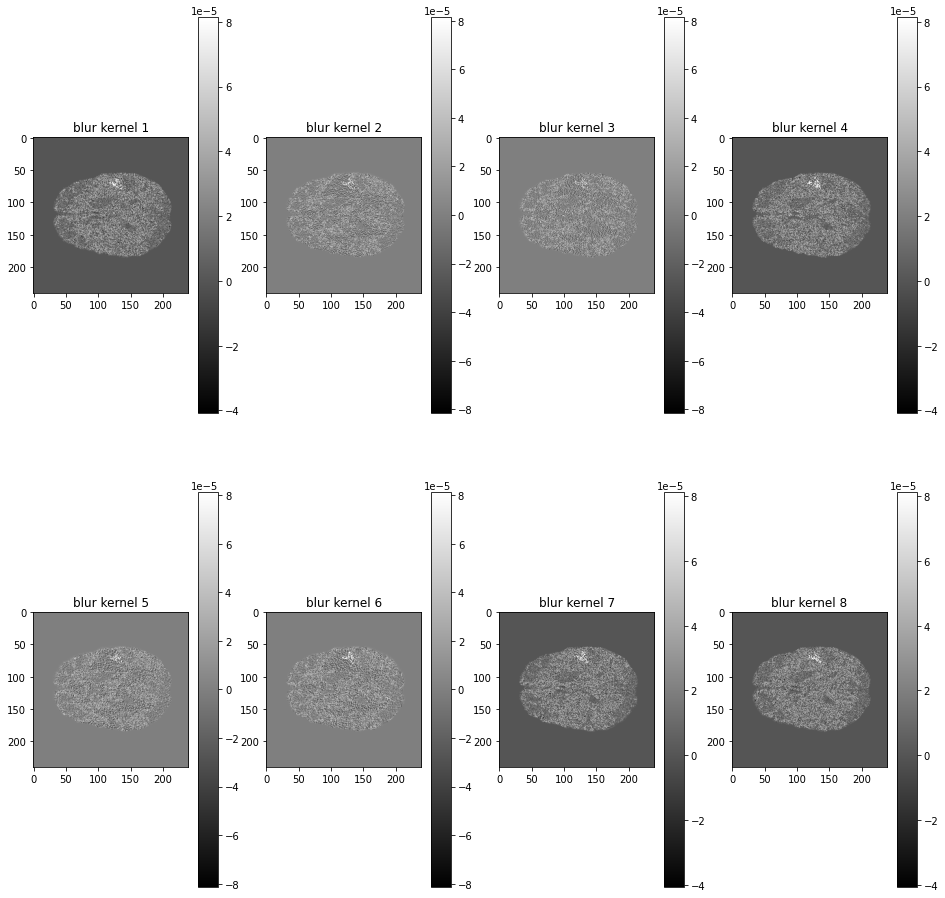

In [ ]:
import cv2 as cv

plt.figure(figsize=[16,16])
for i in range(blurred.shape[3]):
    plt.subplot(2,4,i+1);
    motion_blur = dst = cv.filter2D(np.squeeze(test_blur_slice),-1,blur_kernels_np[i]);
    subtraction = blurred[0,:,:,i] - motion_blur;
    plt.imshow(subtraction,cmap='gray');
    plt.title('blur kernel '+ str(i+1));
    plt.colorbar()
    # There is only e-5 of difference, which suggests that tensorflow is carrying out the desired transformations

## The difference with respect to the original image 

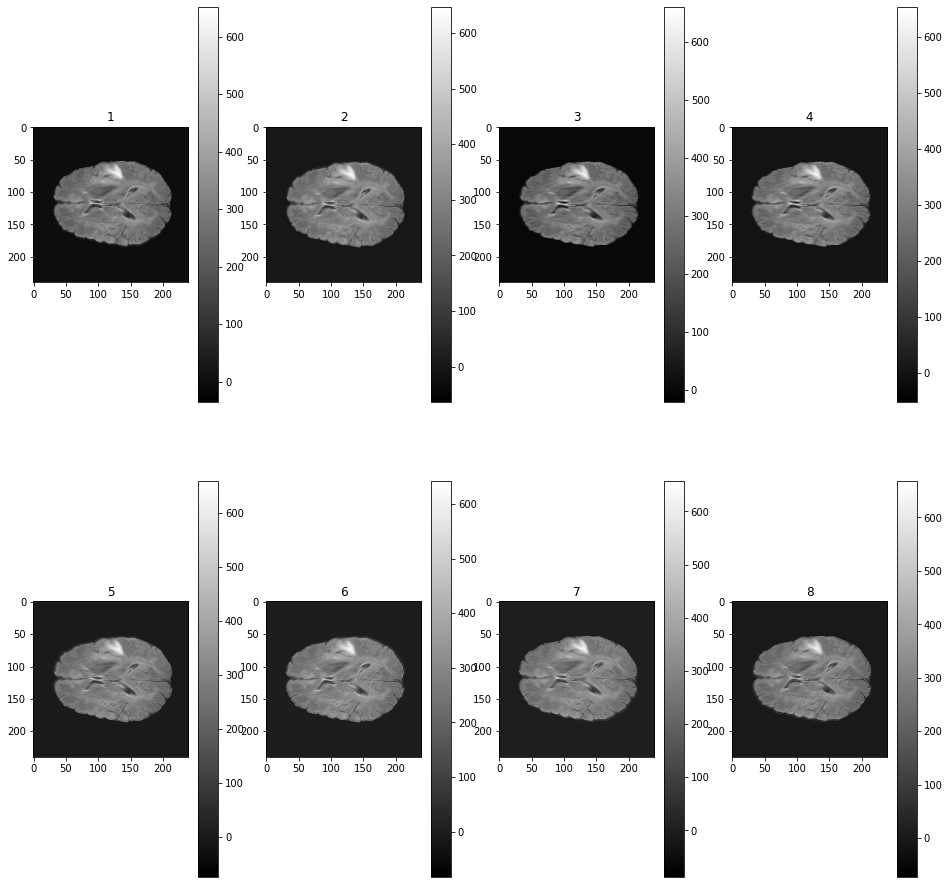

In [ ]:
plt.figure(figsize=[16,16])
for i in range(blurred.shape[3]):
    plt.subplot(2,4,i+1);
    subtraction = blurred[0,:,:,i] - np.squeeze(test_blur_slice);
    plt.imshow(subtraction,cmap='gray');
    plt.title(i+1);
    plt.colorbar()

## Display Blurs

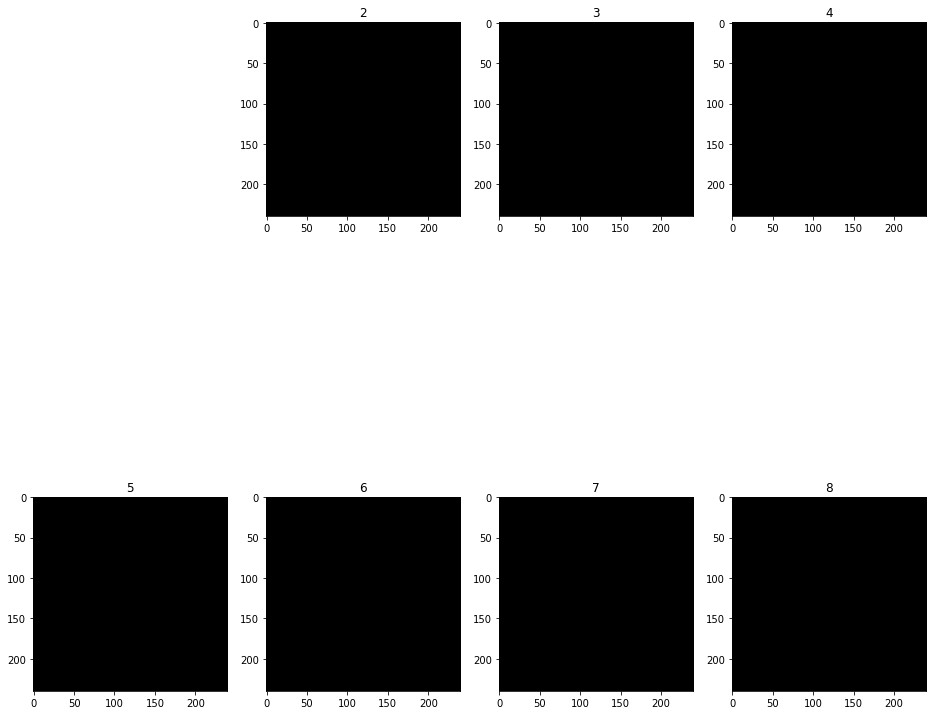

In [ ]:
plt.figure(figsize=[16,16])
for i in range(1,blurred.shape[3]):
    plt.subplot(2,4,i+1);
    current_sub = np.rot90(blurred[0,:,:,i]) - np.rot90(blurred[0,:,:,i-1]) #to view subtractions
    # plt.imshow(np.rot90(blurred[0,:,:,i]),cmap='gray');
    plt.imshow(current_sub,cmap='gray');
    plt.title(i+1);

# Probabilistic Optimization Function

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

class ProbsApproxCatLayer(tf.keras.layers.Layer):
    def __init__(self, N=8):
        super(ProbsApproxCatLayer, self).__init__()
        self.N = N
        initializer = tf.random_normal_initializer()
        # create initial values based on N
        self.logits = tf.Variable(initial_value=initializer([self.N]), trainable=True, dtype='float32')

    @tf.function
    def get_temp(self):
        dist = tfp.distributions.RelaxedOneHotCategorical(0.5, self.logits*10)
        #dist = tfp.distributions.Categorical(self.logits)
        soft_choice = dist.sample()
        ## JUST ADD ROUNDING AS A TRICK/discretize
        hard_choice = tf.eye(self.N)[tf.argmax(soft_choice)] #creates 8 ID matrices, but then selects only 1 based on soft_choice

        choice = tf.stop_gradient(hard_choice - soft_choice) + soft_choice
                  # VALUE OF CHOICE = hard_choice, BUT GRADIENT = soft_choice
                  # HardChoice = The Value we display
                  # SoftChoice is the value we Optimize
        return choice

    @tf.function
    def call(self, inputs):
        choice = self.get_temp()
        # mixing, assume shape of [B, K, H, W, C], where K is choice dimension
        # choice is now of shape [K], what shape should it be broadcast to for the next expression to work?
        # hint you've already done this!
        outputs = tf.math.reduce_sum(inputs*tf.reshape(choice, (1, 1, 1, 1,self.N)), axis=-1, keepdims=True)
        outputs = tf.squeeze(outputs,axis=0)
                # mixing, assume shape of [B, H, W, K], where K is choice dimension --> we changed it to this
        return outputs

# U_NET_2

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization
import tensorflow as tf

def create_unet(encoding_layer=None, N=8, num_classes=1): #0 background, 1 non-tumor closeby, 2 tumorous tissue --> CLASSES
    if encoding_layer is None:
      input_layer = Input(shape=(240, 240, 1))
    else:
      input_layer = Input(shape = (240,240,1)) 

    Blurred_input = Conv2D_Blur()(input_layer)
    x = encoding_layer(Blurred_input)
    # down path
    start_filters = 8
    skip_layers = []
    x = BatchNormalization()(x)
    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        skip_layers.append(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    # up path
    for i in range(3):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1) #for first and last layer, 2nd to last and 2nd, 3rd and 3rd to last
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    output = Conv2D(num_classes, 1, activation='softmax')(x)
    # output = Conv2D(1, 1, activation='softmax')(output)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


# Run & Fit Model

In [ ]:
probs = ProbsApproxCatLayer(8)
unet_model = create_unet(probs,8, 4)
batch_size = 9
epochs = 50
unet_model.summary()
unet_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#unet_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d__blur_2 (Conv2D_Blur)    (None, 240, 240, 8)  72          input_3[0][0]                    
__________________________________________________________________________________________________
probs_approx_cat_layer (ProbsAp (None, 240, 240, 1)  8           conv2d__blur_2[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 1)  4           probs_approx_cat_layer[0][0]     
____________________________________________________________________________________________

## Train

In [ ]:
x_train.shape

(296, 240, 240)

In [ ]:
x_train_2 = np.copy(x_train)
x_train_3 = np.copy(x_train_2)
x_train_4 = np.copy(x_train_3)

for index in range (len(x_train)):
  x_train_2[i,:,:] = x_train_2[i,:,:]/(np.max(np.max(x_train_2[i,:,:]))) #normalize by subject
  # x_train_4[i,:,:] = (x_train_4[i,:,:] - np.mean(x_train_4[i,:,:]))/np.std(x_train_4[i,:,:])
  
# x_train_3 = x_train_3/(np.max(np.max(x_train_3)))#normalized images between 0 and 1 across all subjects



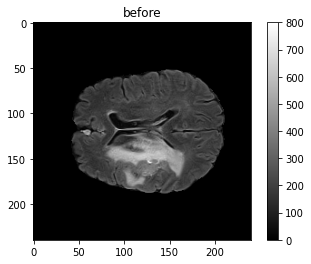

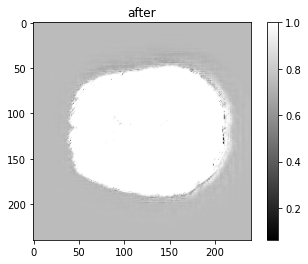

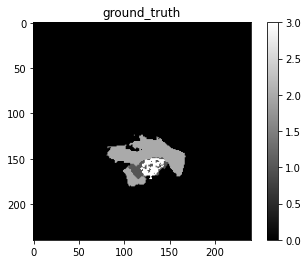

In [ ]:
# unet_trial = unet_model_simple(x_train[1:2,:,:])
test_blur_slice = x_train_2[14:15,:,:];
# label_blur_slice = y_train[1:2, :, :]
blurred = unet_model.predict(test_blur_slice);

plt.imshow(np.squeeze(test_blur_slice,axis=0),cmap = 'gray')
plt.title('before')
plt.colorbar()

plt.figure()

sum_image = np.zeros((240,240))
for i in range(1,4):
    sum_image += blurred[0,:,:,i];

plt.imshow(sum_image,cmap = 'gray')
plt.title('after')
plt.colorbar()

plt.figure()
plt.imshow(np.squeeze(y_train[14:15,:,:], axis = 0),cmap = 'gray')
plt.title('ground_truth')
plt.colorbar()

In [ ]:
train_accuracy = [];
val_accuracy = [];
train_loss = [];
val_loss = [];
tot_logits = [];
all_logits = []
scaled_choice = []
epochs = 40
for e in range(epochs):
    print(f"Logits = {tf.nn.softmax(unet_model.layers[2].logits.numpy()*10)}")
    print(f"Scaled choice = {unet_model.layers[2].get_temp().numpy()}")
    history = unet_model.fit(x_train_2, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test))
    train_accuracy.append(history.history['accuracy']);
    train_loss.append(history.history['loss']);
    val_accuracy.append(history.history['val_accuracy']);
    val_loss.append(history.history['val_loss']);
    all_logits.append(tf.nn.softmax(unet_model.layers[2].logits.numpy()*10))
    scaled_choice.append(unet_model.layers[2].get_temp().numpy())


Logits = [0.24483417 0.10312231 0.1186602  0.08113654 0.1894177  0.06975356
 0.05293147 0.14014404]
Scaled choice = [0. 0. 1. 0. 0. 0. 0. 0.]
33/33 [==============================] - 5s 81ms/step - loss: 0.9084 - accuracy: 0.6903 - val_loss: 0.2460 - val_accuracy: 0.9675
Logits = [0.2716873  0.09163516 0.13407001 0.07922968 0.17632301 0.0661202
 0.05144008 0.12949462]
Scaled choice = [0. 0. 0. 0. 0. 0. 0. 1.]
33/33 [==============================] - 2s 47ms/step - loss: 0.1256 - accuracy: 0.9716 - val_loss: 0.1538 - val_accuracy: 0.9675
Logits = [0.27381474 0.08836816 0.13453273 0.08264017 0.17592408 0.06711646
 0.04985755 0.1277461 ]
Scaled choice = [0. 0. 0. 0. 1. 0. 0. 0.]
33/33 [==============================] - 2s 47ms/step - loss: 0.1136 - accuracy: 0.9716 - val_loss: 0.1510 - val_accuracy: 0.9675
Logits = [0.27692914 0.0884875  0.13198845 0.08267333 0.17496671 0.06961843
 0.04886512 0.12647133]
Scaled choice = [1. 0. 0. 0. 0. 0. 0. 0.]
33/33 [==============================] - 2s

## Plotting Results

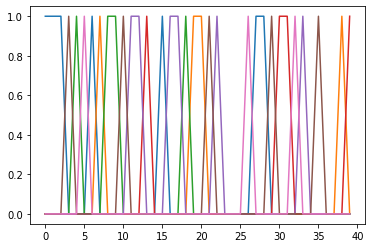

In [ ]:

scale_1 = []
scale_2 = []
scale_3 = []
scale_4 = []
scale_5 = []
scale_6 = []
scale_7 = []
scale_8 = []

for j in range (len(scaled_choice)):
  current_choice = scaled_choice[j]
  scale_1.append(current_choice[0])
  scale_2.append(current_choice[1])
  scale_3.append(current_choice[2])
  scale_4.append(current_choice[3])
  scale_5.append(current_choice[4])
  scale_6.append(current_choice[5])
  scale_7.append(current_choice[6])
  scale_8.append(current_choice[7])
plt.plot(scale_1, label = 'blur_1')
plt.plot(scale_2, label = 'blur_2')
plt.plot(scale_3, label = 'blur_3')
plt.plot(scale_4, label = 'blur_4')
plt.plot(scale_5, label = 'blur_5')
plt.plot(scale_6, label = 'blur_6')
plt.plot(scale_7, label = 'blur_7')

Text(0.5, 1.0, 'Probability of blur selection as least detrimental')

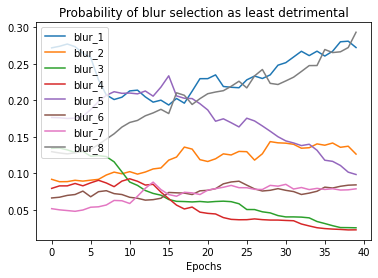

In [ ]:
logit_1 = []
logit_2 = []
logit_3 = []
logit_4 = []
logit_5 = []
logit_6 = []
logit_7 = []
logit_8 = []

for j in range (len(all_logits)):
  current_choice = all_logits[j]
  logit_1.append(current_choice[0])
  logit_2.append(current_choice[1])
  logit_3.append(current_choice[2])
  logit_4.append(current_choice[3])
  logit_5.append(current_choice[4])
  logit_6.append(current_choice[5])
  logit_7.append(current_choice[6])
  logit_8.append(current_choice[7])



plt.plot(logit_1, label = 'blur_1')
plt.plot(logit_2, label = 'blur_2')
plt.plot(logit_3, label = 'blur_3')
plt.plot(logit_4, label = 'blur_4')
plt.plot(logit_5, label = 'blur_5')
plt.plot(logit_6, label = 'blur_6')
plt.plot(logit_7, label = 'blur_7')
plt.plot(logit_8, label = 'blur_8')

plt.legend(loc = 'upper left')
plt.xlabel('Epochs')
plt.title('Probability of blur selection as least detrimental')

Text(0.5, 0, 'Epochs')

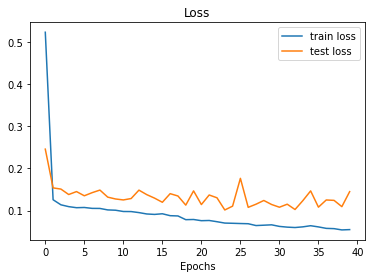

In [ ]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='test loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

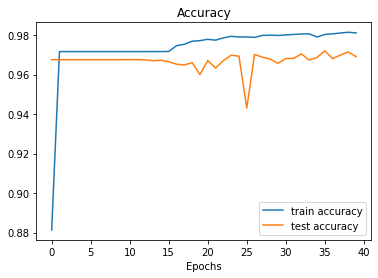

In [ ]:
plt.plot(train_accuracy,label='train accuracy')
plt.plot(val_accuracy,label='test accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

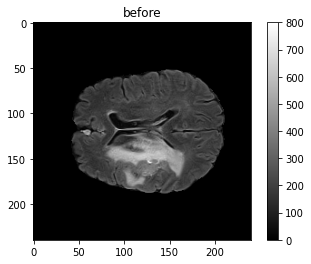

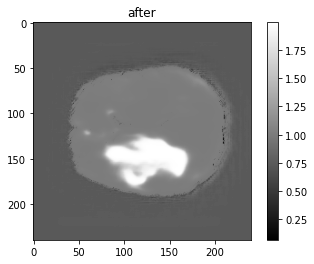

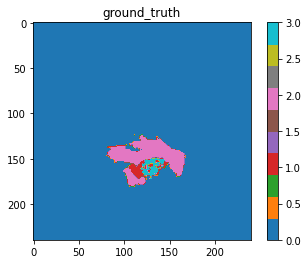

In [ ]:
# unet_trial = unet_model_simple(x_train[1:2,:,:])
test_blur_slice = x_train_2[14:15,:,:];
# label_blur_slice = y_train[1:2, :, :]
blurred = unet_model.predict(test_blur_slice);

plt.imshow(np.squeeze(test_blur_slice,axis=0),cmap = 'gray')
plt.title('before')
plt.colorbar()

plt.figure()

for i in range(1,4):
    sum_image += blurred[0,:,:,i];

plt.imshow(sum_image, cmap = 'gray')

plt.title('after')
plt.colorbar()

plt.figure()
plt.imshow(np.squeeze(y_train[14:15,:,:], axis = 0),cmap = 'tab10')
plt.title('ground_truth')
plt.colorbar()

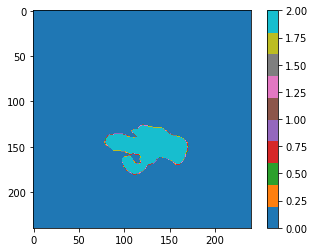

In [ ]:
blurred_2 = np.squeeze(blurred, axis = 0)
plt.imshow(np.argmax(blurred_2, axis=-1), cmap='tab10')
plt.colorbar()

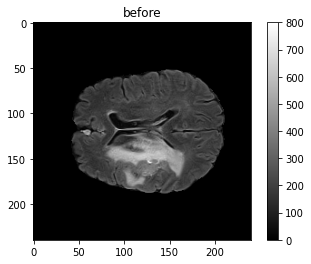

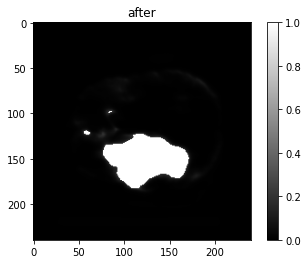

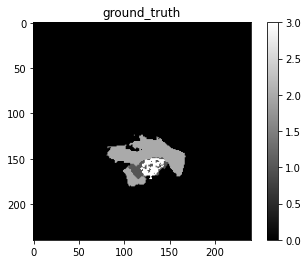

In [ ]:
# unet_trial = unet_model_simple(x_train[1:2,:,:])
test_blur_slice = x_train_2[14:15,:,:];
# label_blur_slice = y_train[1:2, :, :]
blurred = unet_model.predict(test_blur_slice);

plt.imshow(np.squeeze(test_blur_slice,axis=0),cmap = 'gray')
plt.title('before')
plt.colorbar()

plt.figure()

sum_image = np.zeros((240,240))
for i in range(1,4): 
    temp = blurred[0,:,:,i];
    sum_image += temp;

sum_image[np.where(sum_image > 0.2)] = 1;
plt.imshow(sum_image,cmap = 'gray')
plt.title('after')
plt.colorbar()

plt.figure()
plt.imshow(np.squeeze(y_train[14:15,:,:], axis = 0),cmap = 'gray')
plt.title('ground_truth')
plt.colorbar()

In [ ]:
blurred[np.where(blurred>0.5)] = 1;
blurred[np.where(blurred<1)] = 0;

blurred.shape

(1, 240, 240, 1)

## Test

In [ ]:
for e in range(epochs):
    print(f"Probs = {tf.nn.softmax(unet_model.layers[2].logits.numpy()*10)}")
    print(f"Scaled choice = {unet_model.layers[2].get_temp().numpy()}")
    history = unet_model.fit(x_test, y_test, batch_size=batch_size, epochs=1)

Probs = [0.27211034 0.12619223 0.02524788 0.02246499 0.09824299 0.08404338
 0.07863849 0.2930597 ]
Scaled choice = [0. 1. 0. 0. 0. 0. 0. 0.]
9/9 [==============================] - 1s 82ms/step - loss: 0.1008 - accuracy: 0.9711
Probs = [0.26535273 0.12820685 0.02526028 0.02257737 0.09726641 0.086788
 0.07905046 0.29549792]
Scaled choice = [1. 0. 0. 0. 0. 0. 0. 0.]
9/9 [==============================] - 0s 36ms/step - loss: 0.1026 - accuracy: 0.9705
Probs = [0.26333112 0.12855448 0.02494068 0.0225604  0.09734242 0.08719986
 0.0770945  0.29897654]
Scaled choice = [0. 0. 0. 0. 0. 0. 0. 1.]
9/9 [==============================] - 0s 37ms/step - loss: 0.1026 - accuracy: 0.9722
Probs = [0.26318294 0.12886475 0.0246834  0.022543   0.0969701  0.08729023
 0.07608187 0.30038366]
Scaled choice = [0. 0. 0. 0. 0. 0. 0. 1.]
9/9 [==============================] - 0s 36ms/step - loss: 0.0991 - accuracy: 0.9701
Probs = [0.25826368 0.13115294 0.02458245 0.0225284  0.09524037 0.08755649
 0.07595055 0.30472

1. Check Labels are good for center slices
  a. if not change what slices we look @

2. re-watch lab 13, and make sure that custom layers do what we want

3. text colin

# Binary Cross ENTROPY UNET

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, BatchNormalization
import tensorflow as tf

def create_unet_binary(encoding_layer=None, N=8, num_classes=1): #0 background, 1 non-tumor closeby, 2 tumorous tissue --> CLASSES
    if encoding_layer is None:
      input_layer = Input(shape=(240, 240, 1))
    else:
      input_layer = Input(shape = (240,240,1)) 

    Blurred_input = Conv2D_Blur()(input_layer)
    x = encoding_layer(Blurred_input)
    # down path
    start_filters = 8
    skip_layers = []
    x = BatchNormalization()(x)
    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        skip_layers.append(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    # up path
    for i in range(3):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1) #for first and last layer, 2nd to last and 2nd, 3rd and 3rd to last
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    # output = Conv2D(1, 1, activation='softmax')(output)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


In [ ]:
x_train_binary = np.copy(x_train)


for index in range (len(x_train)):
  x_train_2_binary[i,:,:] = x_train_binary[i,:,:]/(np.max(np.max(x_train_2[i,:,:]))) #normalize by subject


In [ ]:
probs = ProbsApproxCatLayer(8)
unet_model_binary = create_unet_binary(probs,8, 1)
batch_size = 9
epochs = 50
unet_model_binary.summary()
unet_model_binary.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
train_accuracy = [];
val_accuracy = [];
train_loss = [];
val_loss = [];
tot_logits = [];
all_logits = []
scaled_choice = []
epochs = 40
for e in range(epochs):
    print(f"Logits = {tf.nn.softmax(unet_model_binary.layers[2].logits.numpy()*10)}")
    print(f"Scaled choice = {unet_model_binary.layers[2].get_temp().numpy()}")
    history = unet_model_binary.fit(x_train_binary, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test))
    train_accuracy.append(history.history['accuracy']);
    train_loss.append(history.history['loss']);
    val_accuracy.append(history.history['val_accuracy']);
    val_loss.append(history.history['val_loss']);
    all_logits.append(tf.nn.softmax(unet_model_binary.layers[2].logits.numpy()*10))
    scaled_choice.append(unet_model_binary.layers[2].get_temp().numpy())

#UNET_without encoding layer

In [ ]:
#NORMALIZE --> 
def create_unet_simple(encoding_layer=None, N=8, num_classes=1): #0 background, 1 non-tumor closeby, 2 tumorous tissue --> CLASSES
    if encoding_layer is None:
      input_layer = Input(shape=(240, 240, 1))
    else:
      input_layer = Input(shape = (240,240,1)) 

    # Blurred_input = Conv2D_Blur()(input_layer)
    # x = encoding_layer(Blurred_input)
    x = input_layer
    # down path
    start_filters = 8
    skip_layers = []

    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        skip_layers.append(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x) 
    # up path
    for i in range(3):
        x = UpSampling2D()(x) 
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1) #for first and last layer, 2nd to last and 2nd, 3rd and 3rd to last
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(1, 1, activation='sigmoid')(x)
    # output *= 1000
    # output_2 = Conv2D(1, 1, activation='softmax')(output)
    # output = Conv2D(1, 1, activation='softmax')(output_prev)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
probs = ProbsApproxCatLayer(8)
unet_model_simple = create_unet_simple(probs,8, 1)
batch_size = 9
epochs = 33
unet_model_simple.summary()
unet_model_simple.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 240, 240, 8)  80          input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 240, 240, 8)  584         conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 120, 120, 8)  0           conv2d_61[0][0]                  
____________________________________________________________________________________________

In [ ]:
# for e in range(epochs):
    # print(f"Probs = {tf.nn.sigmoid(unet_model.layers[2].probs.numpy()*10)}")
    # print(f"Scaled choice = {unet_model.layers[2].get_temp().numpy()}")
unet_model_simple.fit(x_train_2, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/33
33/33 [==============================] - 3s 51ms/step - loss: 0.5029 - accuracy: 0.9100 - val_loss: 0.1452 - val_accuracy: 0.9675
Epoch 2/33
33/33 [==============================] - 1s 39ms/step - loss: 0.1178 - accuracy: 0.9720 - val_loss: 0.1398 - val_accuracy: 0.9675
Epoch 3/33
33/33 [==============================] - 1s 40ms/step - loss: 0.1047 - accuracy: 0.9728 - val_loss: 0.1457 - val_accuracy: 0.9675
Epoch 4/33
33/33 [==============================] - 1s 40ms/step - loss: 0.0935 - accuracy: 0.9714 - val_loss: 0.1166 - val_accuracy: 0.9667
Epoch 5/33
33/33 [==============================] - 1s 40ms/step - loss: 0.0901 - accuracy: 0.9723 - val_loss: 0.1147 - val_accuracy: 0.9675
Epoch 6/33
33/33 [==============================] - 1s 40ms/step - loss: 0.0765 - accuracy: 0.9716 - val_loss: 0.1107 - val_accuracy: 0.9627
Epoch 7/33
33/33 [==============================] - 1s 40ms/step - loss: 0.0766 - accuracy: 0.9750 - val_loss: 0.1045 - val_accuracy: 0.9738
Epoch 8/33
33

In [ ]:
# for e in range(epochs):
    # print(f"Probs = {tf.nn.sigmoid(unet_model.layers[0].probs.numpy()*10)}")
    # print(f"Scaled choice = {unet_model.layers[0].get_temp().numpy()}")
unet_model_simple.fit(x_test, y_test, batch_size=batch_size, epochs=epochs)

Epoch 1/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5030 - accuracy: 0.9674
Epoch 2/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5033 - accuracy: 0.9674
Epoch 3/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5019 - accuracy: 0.9675
Epoch 4/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5014 - accuracy: 0.9675
Epoch 5/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5024 - accuracy: 0.9674
Epoch 6/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5020 - accuracy: 0.9675
Epoch 7/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5014 - accuracy: 0.9675
Epoch 8/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5014 - accuracy: 0.9675
Epoch 9/33
9/9 [==============================] - 0s 34ms/step - loss: 0.5014 - accuracy: 0.9675
Epoch 10/33
9/9 [==============================] - 0s 33ms/step - loss: 0.5014 - accuracy: 0.9675
Epoch 11/33
9/9 [============

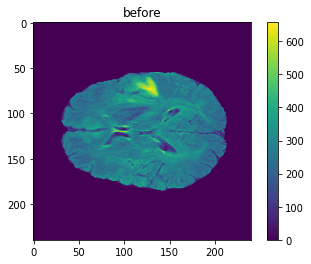

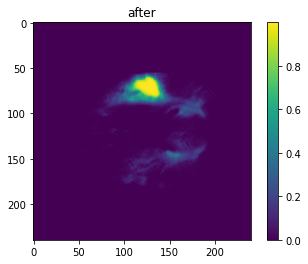

In [ ]:
# unet_trial = unet_model_simple(x_train[1:2,:,:])
test_blur_slice = x_train_2[1:2,:,:];
# label_blur_slice = y_train[1:2, :, :]
blurred = unet_model_simple.predict(test_blur_slice);

plt.imshow(np.squeeze(test_blur_slice,axis=0))
plt.title('before')
plt.colorbar()

plt.figure()
plt.imshow(np.squeeze(np.squeeze(blurred, axis = 0),axis=-1))
plt.title('after')
plt.colorbar()


In [ ]:
np.unique(test_blur_slice)


array([0.        , 0.0006963 , 0.00081235, 0.00088971, 0.00096708,
       0.00100576, 0.00104445, 0.00108313, 0.0011605 , 0.00123786,
       0.00127655, 0.00131523, 0.0013926 , 0.00143128, 0.00150865,
       0.00154733, 0.00158601, 0.0016247 , 0.00166338, 0.00170206,
       0.00174075, 0.00177943, 0.00181811, 0.00185679, 0.00189548,
       0.00193416, 0.00197284, 0.00201153, 0.00205021, 0.00208889,
       0.00212758, 0.00216626, 0.00220494, 0.00224363, 0.00228231,
       0.00232099, 0.00235968, 0.00239836, 0.00243704, 0.00247573,
       0.00251441, 0.00255309, 0.00259178, 0.00263046, 0.00266914,
       0.00270783, 0.00274651, 0.00278519, 0.00282388, 0.00286256,
       0.00290124, 0.00293992, 0.00297861, 0.00301729, 0.00305597,
       0.00309466, 0.00313334, 0.00317202, 0.00321071, 0.00324939,
       0.00328807, 0.00332676, 0.00336544, 0.00340412, 0.00344281,
       0.00348149, 0.00352017, 0.00355886, 0.00359754, 0.00363622,
       0.00367491, 0.00371359, 0.00375227, 0.00379096, 0.00382

In [ ]:
np.unique(blurred)


array([3.0932136e-13, 4.6272307e-13, 6.7429780e-13, ..., 9.8824573e-01,
       9.8826551e-01, 9.8839241e-01], dtype=float32)